<a href="https://colab.research.google.com/github/ollihansen90/ChaBoDoc_Chatbot/blob/main/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ChaBoDoc-Chatbot

## Importiere Zeugs

In [3]:
import sys, os
if "google.colab" in sys.modules:
    if os.getcwd() == "/content":
        !git clone "https://github.com/ollihansen90/ChaBoDoc_Chatbot.git"
        os.chdir("ChaBoDoc_Chatbot")

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem.lancaster import LancasterStemmer
nltk.download('punkt')

STEMMER = LancasterStemmer()

def bagofwords(s, words):
    bag = [0 for _ in range((len(words)))]
    s_words = nltk.word_tokenize(s)
    s_words = [STEMMER.stem(word.lower()) for word in s_words]
    print(s_words)

    for se in s_words:
        for i, w in enumerate(words):
            if w==se:
                bag[i] = 1
        
    return torch.tensor(bag).float()

print(bagofwords("Hallo, mein Name ist Olli", ["hallo", "oll"][::-1]))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['hallo', ',', 'mein', 'nam', 'ist', 'oll']
tensor([1., 1.])
cuda


## Datenverarbeitung und Vorbereitung

In [4]:
import json
from stopwords import worte

with open("intents.json") as file:
    data = json.load(file)

words = []
labels = []
docs_x = []
docs_y = []

for intent in data["intents"]:
    for pattern in intent["patterns"]:
        wrds = nltk.word_tokenize(pattern)
        words.extend(wrds)
        docs_x.append(wrds)
        docs_y.append(intent["tag"])
    
    if intent["tag"] not in labels:
        labels.append(intent["tag"])

"""print(words)
print(labels)
print(docs_x)
print(docs_y)"""

words = [w for w in words if not w in worte]
words = [STEMMER.stem(w.lower()) for w in words if w != "?"]
words = sorted(list(set(words)))
labels = sorted(labels)

training = []
output = []

out_empty = [0 for _ in range(len(labels))]

for x, doc in enumerate(docs_x):
    bag = []

    wrds = [STEMMER.stem(w.lower()) for w in doc]

    for w in words:
        if w in wrds:
            bag.append(1)
        else:
            bag.append(0)

    output_row = out_empty[:]
    output_row[labels.index(docs_y[x])] = 1
    training.append(bag)
    output.append(output_row)

training = torch.tensor(training).float().to(device)
output = torch.tensor(output).float().to(device)

## "Gehirn"

In [5]:
class Classifier(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.layer1 = nn.Linear(dim_in, dim_out)
    
    def forward(self, x):
        out = self.layer1(x)
        return out

dim_in = len(training[0])
dim_out = len(output[0])
model = Classifier(dim_in, dim_out).to(device)

print(dim_in, dim_out)

507 14


## Training "Gehirn"

torch.Size([525, 507]) torch.Size([525, 14])
0 2.63671612739563
100 2.2750208377838135
200 1.95586097240448
300 1.6805469989776611
400 1.446341633796692
500 1.2483632564544678
600 1.0813473463058472
700 0.9404674768447876
800 0.8215458989143372
900 0.7210204005241394


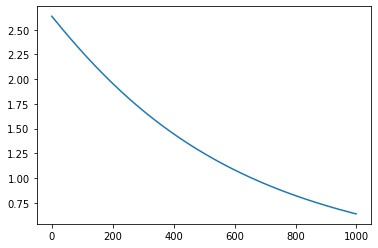

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = F.cross_entropy

n_epochs = 1000
lossliste = torch.zeros(n_epochs)

print(training.shape, output.shape)
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(training)
    loss = loss_func(out, output)
    loss.backward()
    optimizer.step()
    lossliste[epoch] = loss.item()
    if epoch%100==0:
        print(epoch, loss.item())

plt.figure()
plt.plot(lossliste.cpu().numpy())
plt.show()


## Verarbeite Input

In [7]:
from random import choice

def predict(message, model, words, labels, data):
    message = message.lower()
    result = model(bagofwords(message, words).to(device))
    result_index = torch.argmax(result)
    tag = labels[result_index]

    if result[result_index] > 0.9:
        for tg in data["intents"]:
            if tg["tag"] == tag:
                responses = tg["responses"]
        response = choice(responses)
    else:
        response = "Come again for Big Fudge?"
    return tag, response

## Verständnistest

In [8]:
model.eval()

print("Chatbot:", "Hallo :-)")
user_input = input("User:    ")
tag, response = predict(user_input, model, words, labels, data)
print("Chatbot glaubt, das Label ist", tag)
print("Chatbot:", response)

print("Chatbot:", "Wie geht es dir?")
user_input = input("User:    ")
tag, response = predict(user_input, model, words, labels, data)
print("Chatbot glaubt, das Label ist", tag)
print("Chatbot:", response)

print("Chatbot:", "Ich muss jetzt leider gehen... Auf Wiedersehen :-)")
user_input = input("User:    ")
tag, response = predict(user_input, model, words, labels, data)
print("Chatbot glaubt, das Label ist", tag)
print("Chatbot:", response)

Chatbot: Hallo :-)
User:    Na du
['na', 'du']
Chatbot glaubt, das Label ist greeting
Chatbot: Es freut mich, Dich hier zu treffen!
Chatbot: Wie geht es dir?
User:    Sehr schlecht
['sehr', 'schlecht']
Chatbot glaubt, das Label ist bad words
Chatbot: Mhh... Ich spüre negative Vibes.
Chatbot: Ich muss jetzt leider gehen... Auf Wiedersehen :-)
User:    Bis morgen
['bis', 'morg']
Chatbot glaubt, das Label ist greeting
Chatbot: Come again for Big Fudge?


# Alte Tests

In [ ]:
import json
import urllib.request
with urllib.request.urlopen("https://raw.githubusercontent.com/inb-luebeck/chat_bot/main/Melinda/intents.json?token=GHSAT0AAAAAABQNOK46CRADPTF4EY5NRSGWYO4D7XA") as file:
    data = json.loads(file.read().decode())
print(data)

HTTPError: ignored

In [ ]:
import pickle
import cloudpickle as cp

loaded_pickle_object = cp.load(urllib.request.urlopen("https://github.com/inb-luebeck/chat_bot/blob/main/Melinda/model/data.pickle?raw=true", "rb"))
print(loaded_pickle_object)


TypeError: ignored